In [138]:
import requests
from pymongo import MongoClient
from pymongo import GEOSPHERE
import pandas as pd
import json

In [139]:
import os
import requests
import json
from dotenv import load_dotenv
import pandas as pd

import geopandas as gpd
from cartoframes.viz import Map, Layer, popup_element

import folium
from folium import Choropleth, Circle, Marker, Icon, Map
from folium.plugins import HeatMap, MarkerCluster
import pandas as pd
import geopy
from geopy import distance 

In [183]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import requests
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [184]:
# Matplotlib inline to visualize Matplotlib graphs
%matplotlib inline
%config Inlinebackend.figure_format= 'retina'

In [185]:
# Configuration to set so that all the Seaborn figs come out with this size
sns.set_context("poster")
sns.set(rc={"figure.figsize": (12.,6.)})
sns.set_style("whitegrid")

# First of all, let's see how many colleagues we have in our company and see how much they represent in percentage

In [140]:
designers = 20
ui_ux_engineers = 5
frontend_dev = 10
data_engineers = 15
backend_dev = 5
account_managers = 20
maint = 1
executives = 10
ceo = 1

In [141]:
total_company = designers + ui_ux_engineers + frontend_dev + data_engineers + backend_dev + account_managers + maint + executives + ceo

In [142]:
total_company

87

In [143]:
def weighted_colleague(string):
    return (string/total_company)*100

In [144]:
weighted_colleague(designers)

22.988505747126435

In [145]:
weighted_colleague(ui_ux_engineers)

5.747126436781609

In [146]:
weighted_colleague(frontend_dev)

11.494252873563218

In [147]:
weighted_colleague(data_engineers)

17.24137931034483

In [148]:
weighted_colleague(backend_dev)

5.747126436781609

In [149]:
weighted_colleague(maint)

1.1494252873563218

In [150]:
weighted_colleague(account_managers)

22.988505747126435

In [151]:
weighted_colleague(executives)

11.494252873563218

In [152]:
weighted_colleague(ceo)

1.1494252873563218

# After seeing that, I decided to give priority to locations where either companies related to the design field or where successful startups are based at in order for me to have a first filter of the main database in Mongo

In [153]:
from pymongo import MongoClient
client = MongoClient("localhost:27017")

In [17]:
db = client["Ironhack"]
c = db.get_collection("companies")

In [19]:
condition_one = {"description": {"$regex": "design"}}
condition_two = {"tag_list": {"$regex": "design"}}
condition_three = {"name": {"$regex": "design"}}
condition_four = {"category_code": {"$regex": "design"}}
condition_five = {"total_money_raised": {"$regex": "M"}}
condition_six = {"total_money_raised": {"$regex": "B"}}
condition_seven = {}

In [20]:
projection = {"name": 1, "number_of_employees": 1, "total_money_raised": 1,"offices.country_code": 1,"offices.city": 1, "_id":0}
result_gaming = list(c.find({
    "$or": [
         condition_one,
          condition_two, condition_three,
            condition_four,
          condition_five,condition_six
    ], 
    "number_of_employees": {"$gte": 3000}
}, projection))


result_gaming[0]

{'name': 'Facebook',
 'number_of_employees': 5299,
 'total_money_raised': '$2.43B',
 'offices': [{'city': 'Menlo Park', 'country_code': 'USA'},
  {'city': 'Dublin', 'country_code': 'IRL'},
  {'city': 'New York', 'country_code': 'USA'}]}

In [21]:
len(result_gaming)

31

In [22]:
type(result_gaming)

list

# Moving the result into a database so it's easier to read

In [169]:
df = pd.DataFrame(result_gaming)
df[:5]

,name,number_of_employees,total_money_raised,offices
0,Facebook,5299,$2.43B,"[{'city': 'Menlo Park', 'country_code': 'USA'}..."
1,eBay,15000,$6.7M,"[{'city': 'San Jose', 'country_code': 'USA'}]"
2,Cisco,63000,$2.5M,"[{'city': 'San Jose', 'country_code': 'USA'}]"
3,Yahoo!,13600,$6.8M,"[{'city': 'Sunnyvale', 'country_code': 'USA'}]"
4,Google,28000,$555M,"[{'city': 'Mountain View', 'country_code': 'US..."


# Let's now create a new column with the info from "offices" so we can have an actual number of offices by company

In [170]:
df["total_offices"] = df["offices"].apply(lambda x: len(x))
df.sort_values(by="total_offices", ascending=False).reset_index().drop(['index'], axis=1)[:5]

,name,number_of_employees,total_money_raised,offices,total_offices
0,Google,28000,$555M,"[{'city': 'Mountain View', 'country_code': 'US...",67
1,Yandex,4000,$5.3M,"[{'city': 'Moscow', 'country_code': 'RUS'}, {'...",9
2,Sapient,10000,$2.4M,"[{'city': 'Boston', 'country_code': 'USA'}, {'...",8
3,Spotify,5000,$533M,"[{'city': 'Luxembourg', 'country_code': 'LUX'}...",7
4,Groupon,10000,$1.15B,"[{'city': 'Chicago', 'country_code': 'USA'}, {...",4


In [25]:
df.offices[0]

[{'city': 'Menlo Park', 'country_code': 'USA'},
 {'city': 'Dublin', 'country_code': 'IRL'},
 {'city': 'New York', 'country_code': 'USA'}]

In [26]:
x = df.offices[0]
x

[{'city': 'Menlo Park', 'country_code': 'USA'},
 {'city': 'Dublin', 'country_code': 'IRL'},
 {'city': 'New York', 'country_code': 'USA'}]

# Let's now create a dictionary so we can have city & number of offices in that city

In [27]:
new_dict = {}

In [28]:
for i in x:
    ciudad = i["city"]
    print(ciudad)
    if ciudad in new_dict.keys():
        new_dict[ciudad] +=1
    else:
        new_dict[ciudad]  =1
new_dict

Menlo Park
Dublin
New York


{'Menlo Park': 1, 'Dublin': 1, 'New York': 1}

In [172]:
city_dict = {}
for item, rows in df.iterrows():
    for i in rows["offices"]:
        ciudad = i["city"]
        if ciudad in city_dict.keys():
            city_dict[ciudad] +=1
        else:
            city_dict[ciudad]  =1
city_dict

{'Menlo Park': 1,
 'Dublin': 2,
 'New York': 6,
 'San Jose': 4,
 'Sunnyvale': 1,
 'Mountain View': 3,
 'Ann Arbor': 1,
 'Atlanta': 2,
 'Austin': 1,
 'Boulder': 1,
 'Cambridge': 2,
 'Chicago': 3,
 'Coppell': 1,
 'Dallas': 2,
 'Denver': 1,
 'Birmingham': 2,
 'Irvine': 1,
 'Kirkland': 1,
 'Tempe': 1,
 'Pittsburgh': 1,
 'San Francisco': 4,
 'Santa Monica': 1,
 'Seattle': 3,
 'Washington': 1,
 'Melbourne': 1,
 'Sydney': 1,
 'Beijing': 2,
 'Guangzhou': 1,
 'Shanghai': 1,
 'Central': 1,
 'Bangalore': 1,
 'Gurgaon': 1,
 'New Delhi': 1,
 'Hyderabad': 1,
 'Mumbai': 1,
 'Tokyo': 2,
 'Osaka': 1,
 'Seoul': 1,
 'Singapore': 1,
 'Taipei': 1,
 '': 2,
 'Helsinki': 1,
 'Paris': 3,
 'Hamburg': 1,
 'Milan': 1,
 'Amsterdam': 2,
 'Oslo': 2,
 'Trondheim': 1,
 'KrakÃ³w': 1,
 'Wroclaw': 1,
 'Moscow': 3,
 'St. Petersburg': 1,
 'Madrid': 2,
 'LuleÃ¥': 1,
 'Stockholm': 2,
 'ZÃ¼rich': 1,
 'London': 2,
 'Manchester': 1,
 'Montreal': 1,
 'Toronto': 1,
 'Waterloo': 1,
 'Buenos Aires': 1,
 'Sao Paulo': 1,
 'Mexico': 1

In [30]:
{k: v for k, v in sorted(city_dict.items(), key=lambda item: item[1])}

{'Menlo Park': 1,
 'Sunnyvale': 1,
 'Ann Arbor': 1,
 'Austin': 1,
 'Boulder': 1,
 'Coppell': 1,
 'Denver': 1,
 'Irvine': 1,
 'Kirkland': 1,
 'Tempe': 1,
 'Pittsburgh': 1,
 'Santa Monica': 1,
 'Washington': 1,
 'Melbourne': 1,
 'Sydney': 1,
 'Guangzhou': 1,
 'Shanghai': 1,
 'Central': 1,
 'Bangalore': 1,
 'Gurgaon': 1,
 'New Delhi': 1,
 'Hyderabad': 1,
 'Mumbai': 1,
 'Osaka': 1,
 'Seoul': 1,
 'Singapore': 1,
 'Taipei': 1,
 'Helsinki': 1,
 'Hamburg': 1,
 'Milan': 1,
 'Trondheim': 1,
 'KrakÃ³w': 1,
 'Wroclaw': 1,
 'St. Petersburg': 1,
 'LuleÃ¥': 1,
 'ZÃ¼rich': 1,
 'Manchester': 1,
 'Montreal': 1,
 'Toronto': 1,
 'Waterloo': 1,
 'Buenos Aires': 1,
 'Sao Paulo': 1,
 'Mexico': 1,
 'Haifa': 1,
 'Tel-Aviv': 1,
 'Istanbul': 1,
 'Dubai': 1,
 'San Diego': 1,
 'Philadelphia': 1,
 'Baguio': 1,
 'Luxembourg': 1,
 'San Rafael': 1,
 'Saint Petersburg': 1,
 'Ekaterinburg': 1,
 'Novosibirsk': 1,
 'Odessa': 1,
 'Kiev': 1,
 'Simferopol': 1,
 'Luzern': 1,
 'Norwalk': 1,
 'Wien': 1,
 'Sarajevo': 1,
 'Zagreb

In [31]:
df.offices[0][0]["country_code"]

'USA'

# Now the same with actual countries

In [32]:
country_dict = {}
for item, rows in df.iterrows():
    for i in rows["offices"]:
        country = i["country_code"]
        if country in country_dict.keys():
            country_dict[country] +=1
        else:
            country_dict[country]  =1
country_dict

{'USA': 60,
 'IRL': 3,
 'AUS': 2,
 'CHN': 5,
 'HKG': 1,
 'IND': 4,
 'JPN': 2,
 'PRK': 1,
 'SGP': 1,
 'TWN': 1,
 'DNK': 2,
 'FIN': 1,
 'FRA': 4,
 'DEU': 2,
 'ITA': 1,
 'NLD': 2,
 'NOR': 3,
 'POL': 2,
 'RUS': 7,
 'ESP': 2,
 'SWE': 3,
 'CHE': 2,
 'GBR': 3,
 'CAN': 3,
 'ARG': 1,
 'BRA': 2,
 'MEX': 1,
 'ISR': 2,
 'TUR': 1,
 'ARE': 1,
 'PHL': 1,
 'LUX': 1,
 'UKR': 3,
 'AUT': 1,
 'BIH': 1,
 'HRV': 1}

In [33]:
{k: v for k, v in sorted(country_dict.items(), key=lambda item: item[1])}

{'HKG': 1,
 'PRK': 1,
 'SGP': 1,
 'TWN': 1,
 'FIN': 1,
 'ITA': 1,
 'ARG': 1,
 'MEX': 1,
 'TUR': 1,
 'ARE': 1,
 'PHL': 1,
 'LUX': 1,
 'AUT': 1,
 'BIH': 1,
 'HRV': 1,
 'AUS': 2,
 'JPN': 2,
 'DNK': 2,
 'DEU': 2,
 'NLD': 2,
 'POL': 2,
 'ESP': 2,
 'CHE': 2,
 'BRA': 2,
 'ISR': 2,
 'IRL': 3,
 'NOR': 3,
 'SWE': 3,
 'GBR': 3,
 'CAN': 3,
 'UKR': 3,
 'IND': 4,
 'FRA': 4,
 'CHN': 5,
 'RUS': 7,
 'USA': 60}

# Let's also add latitude & longitude to the original code so we can get the actual coordinates of each company

In [34]:
# Now with altitude and longitude
projection = {"name": 1, "number_of_employees": 1, "total_money_raised": 1,"offices.country_code": 1,"offices.city": 1,"offices.latitude": 1,"offices.longitude": 1, "_id":0}
result_gaming_latlong = list(c.find({
    "$or": [
         condition_one,
          condition_two, condition_three,
            condition_four,
          condition_five,condition_six
    ], 
    "number_of_employees": {"$gte": 3000}
}, projection))


result_gaming_latlong[0]

{'name': 'Facebook',
 'number_of_employees': 5299,
 'total_money_raised': '$2.43B',
 'offices': [{'city': 'Menlo Park',
   'country_code': 'USA',
   'latitude': 37.41605,
   'longitude': -122.151801},
  {'city': 'Dublin',
   'country_code': 'IRL',
   'latitude': 53.344104,
   'longitude': -6.267494},
  {'city': 'New York',
   'country_code': 'USA',
   'latitude': 40.7557162,
   'longitude': -73.9792469}]}

In [35]:
result_gaming_latlong[0]["offices"][0]["latitude"]

37.41605

# After seeing the result of countries & cities, the data is pointing us towards the USA, especially: New York, San Francisco & San Jose

In [36]:
# Now with altitude and longitude  but filtering for the key cities I'm interested in:
condition_one = {"description": {"$regex": "design"}}
condition_two = {"tag_list": {"$regex": "design"}}
condition_three = {"name": {"$regex": "design"}}
condition_four = {"category_code": {"$regex": "design"}}
condition_five = {"total_money_raised": {"$regex": "M"}}
condition_six = {"total_money_raised": {"$regex": "B"}}
condition_seven = {"number_of_employees": {"$gte": 3000}}
condition_eight = {"offices.city": {"$regex": "York"}}

In [37]:
projection = {"name": 1, "number_of_employees": 1, "total_money_raised": 1,"offices.country_code": 1,"offices.city": 1,"offices.latitude": 1,"offices.longitude": 1, "_id":0}
result_gaming_latlong_nyc = list(c.find({
    "$and": [
        {
            "$or": [
                 condition_one,
                condition_two, condition_three,
                condition_four,
                  condition_five,condition_six
                    ]}, 
    
    condition_seven,condition_eight]}, projection))


result_gaming_latlong_nyc

[{'name': 'Facebook',
  'number_of_employees': 5299,
  'total_money_raised': '$2.43B',
  'offices': [{'city': 'Menlo Park',
    'country_code': 'USA',
    'latitude': 37.41605,
    'longitude': -122.151801},
   {'city': 'Dublin',
    'country_code': 'IRL',
    'latitude': 53.344104,
    'longitude': -6.267494},
   {'city': 'New York',
    'country_code': 'USA',
    'latitude': 40.7557162,
    'longitude': -73.9792469}]},
 {'name': 'Google',
  'number_of_employees': 28000,
  'total_money_raised': '$555M',
  'offices': [{'city': 'Mountain View',
    'country_code': 'USA',
    'latitude': 37.421972,
    'longitude': -122.084143},
   {'city': 'Ann Arbor',
    'country_code': 'USA',
    'latitude': 42.280988,
    'longitude': -83.748882},
   {'city': 'Atlanta',
    'country_code': 'USA',
    'latitude': 33.781466,
    'longitude': -84.387519},
   {'city': 'Austin',
    'country_code': 'USA',
    'latitude': 30.351416,
    'longitude': -97.751382},
   {'city': 'Boulder',
    'country_code': 

In [38]:
len(result_gaming_latlong_nyc)

6

In [39]:
df_nyc = pd.DataFrame(result_gaming_latlong_nyc)
df_nyc

,name,number_of_employees,total_money_raised,offices
0,Facebook,5299,$2.43B,"[{'city': 'Menlo Park', 'country_code': 'USA',..."
1,Google,28000,$555M,"[{'city': 'Mountain View', 'country_code': 'US..."
2,AOL,8000,$1B,"[{'city': 'New York', 'country_code': 'USA', '..."
3,Spotify,5000,$533M,"[{'city': 'Luxembourg', 'country_code': 'LUX',..."
4,Sapient,10000,$2.4M,"[{'city': 'Boston', 'country_code': 'USA', 'la..."
5,CPM Braxis,5400,$100M,"[{'city': 'SÃ£o Paulo', 'country_code': 'BRA',..."


In [40]:
df_nyc.offices[0][2]["city"]

'New York'

In [41]:
x = df_nyc.offices[0]
x

[{'city': 'Menlo Park',
  'country_code': 'USA',
  'latitude': 37.41605,
  'longitude': -122.151801},
 {'city': 'Dublin',
  'country_code': 'IRL',
  'latitude': 53.344104,
  'longitude': -6.267494},
 {'city': 'New York',
  'country_code': 'USA',
  'latitude': 40.7557162,
  'longitude': -73.9792469}]

In [42]:
x[0]["city"]

'Menlo Park'

In [173]:
nyc_list = []

for item, rows in df_nyc.iterrows():
    for i in rows["offices"]:
        nyc_list.append(i)

nyc_list[:5]        

[{'city': 'Menlo Park',
  'country_code': 'USA',
  'latitude': 37.41605,
  'longitude': -122.151801},
 {'city': 'Dublin',
  'country_code': 'IRL',
  'latitude': 53.344104,
  'longitude': -6.267494},
 {'city': 'New York',
  'country_code': 'USA',
  'latitude': 40.7557162,
  'longitude': -73.9792469},
 {'city': 'Mountain View',
  'country_code': 'USA',
  'latitude': 37.421972,
  'longitude': -122.084143},
 {'city': 'Ann Arbor',
  'country_code': 'USA',
  'latitude': 42.280988,
  'longitude': -83.748882}]

In [174]:
df_nyc_coordinates = pd.DataFrame(nyc_list)
df_nyc_coordinates[:5]

,city,country_code,latitude,longitude
0,Menlo Park,USA,37.416050,-122.151801
1,Dublin,IRL,53.344104,-6.267494
2,New York,USA,40.755716,-73.979247
3,Mountain View,USA,37.421972,-122.084143
4,Ann Arbor,USA,42.280988,-83.748882


# Selecting rows based on condition New York & getting rid of the NaN values

In [45]:
df_nyc_coordinates2 = (df_nyc_coordinates[df_nyc_coordinates['city'] == "New York"]).reset_index().drop('index', axis=1) 
df_nyc_coordinates2

,city,country_code,latitude,longitude
0,New York,USA,40.755716,-73.979247
1,New York,USA,40.742220,-74.004489
2,New York,USA,40.731132,-73.991931
3,New York,USA,NaN,NaN
4,New York,USA,40.707872,-74.004731
5,New York,USA,40.756799,-73.976348


In [46]:
df_nyc_coordinates3 = df_nyc_coordinates2[df_nyc_coordinates2['latitude'].notna()]
df_nyc_coordinates3

,city,country_code,latitude,longitude
0,New York,USA,40.755716,-73.979247
1,New York,USA,40.742220,-74.004489
2,New York,USA,40.731132,-73.991931
4,New York,USA,40.707872,-74.004731
5,New York,USA,40.756799,-73.976348


# Doing the same for San Francisco

In [47]:
condition_one = {"description": {"$regex": "design"}}
condition_two = {"tag_list": {"$regex": "design"}}
condition_three = {"name": {"$regex": "design"}}
condition_four = {"category_code": {"$regex": "design"}}
condition_five = {"total_money_raised": {"$regex": "M"}}
condition_six = {"total_money_raised": {"$regex": "B"}}
condition_seven = {"number_of_employees": {"$gte": 3000}}
condition_eight = {"offices.city": {"$regex": "Francisco"}}

In [175]:
projection = {"name": 1, "number_of_employees": 1, "total_money_raised": 1,"offices.country_code": 1,"offices.city": 1,"offices.latitude": 1,"offices.longitude": 1, "_id":0}
result_gaming_latlong_sf = list(c.find({
    "$and": [
        {
            "$or": [
                 condition_one,
                condition_two, condition_three,
                condition_four,
                  condition_five,condition_six
                    ]}, 
    
    condition_seven,condition_eight]}, projection))


result_gaming_latlong_sf[:5]

[{'name': 'eBay',
  'number_of_employees': 15000,
  'total_money_raised': '$6.7M',
  'offices': [{'city': 'San Jose',
    'country_code': 'USA',
    'latitude': 37.295005,
    'longitude': -121.930035}]},
 {'name': 'Cisco',
  'number_of_employees': 63000,
  'total_money_raised': '$2.5M',
  'offices': [{'city': 'San Jose',
    'country_code': 'USA',
    'latitude': 37.408802,
    'longitude': -121.95377}]},
 {'name': 'Adobe Systems',
  'number_of_employees': 7173,
  'total_money_raised': '$0',
  'offices': [{'city': 'San Jose',
    'country_code': 'USA',
    'latitude': 37.320052,
    'longitude': -121.877636}]},
 {'name': 'PayPal',
  'number_of_employees': 300000,
  'total_money_raised': '$197M',
  'offices': [{'city': 'San Jose',
    'country_code': 'USA',
    'latitude': 37.294465,
    'longitude': -121.927696}]}]

In [49]:
len(result_gaming_latlong_sf)

4

In [50]:
df_sf = pd.DataFrame(result_gaming_latlong_sf)
df_sf

,name,number_of_employees,total_money_raised,offices
0,Google,28000,$555M,"[{'city': 'Mountain View', 'country_code': 'US..."
1,Salesforce,3500,$99.9M,"[{'city': 'San Francisco', 'country_code': 'US..."
2,Groupon,10000,$1.15B,"[{'city': 'Chicago', 'country_code': 'USA', 'l..."
3,Sapient,10000,$2.4M,"[{'city': 'Boston', 'country_code': 'USA', 'la..."


In [51]:
df_sf.offices[1][0]["city"]

'San Francisco'

In [176]:
sf_list = []

for item, rows in df_sf.iterrows():
    for i in rows["offices"]:
        sf_list.append(i)

sf_list[:5]

[{'city': 'Mountain View',
  'country_code': 'USA',
  'latitude': 37.421972,
  'longitude': -122.084143},
 {'city': 'Ann Arbor',
  'country_code': 'USA',
  'latitude': 42.280988,
  'longitude': -83.748882},
 {'city': 'Atlanta',
  'country_code': 'USA',
  'latitude': 33.781466,
  'longitude': -84.387519},
 {'city': 'Austin',
  'country_code': 'USA',
  'latitude': 30.351416,
  'longitude': -97.751382},
 {'city': 'Boulder',
  'country_code': 'USA',
  'latitude': 40.021416,
  'longitude': -105.260931}]

In [177]:
df_sf_coordinates = pd.DataFrame(sf_list)
df_sf_coordinates[:5]

,city,country_code,latitude,longitude
0,Mountain View,USA,37.421972,-122.084143
1,Ann Arbor,USA,42.280988,-83.748882
2,Atlanta,USA,33.781466,-84.387519
3,Austin,USA,30.351416,-97.751382
4,Boulder,USA,40.021416,-105.260931


In [54]:
# selecting rows based on condition San Francisco
df_sf_coordinates2 = (df_sf_coordinates[df_sf_coordinates['city'] == "San Francisco"]).reset_index().drop('index', axis=1) 
df_sf_coordinates2

,city,country_code,latitude,longitude
0,San Francisco,USA,37.789803,-122.389757
1,San Francisco,USA,NaN,NaN
2,San Francisco,USA,NaN,NaN
3,San Francisco,USA,37.790880,-122.392521


In [55]:
df_sf_coordinates3 = df_sf_coordinates2[df_sf_coordinates2['latitude'].notna()]
df_sf_coordinates4 = df_sf_coordinates3.reset_index().drop('index', axis=1) 
df_sf_coordinates4

,city,country_code,latitude,longitude
0,San Francisco,USA,37.789803,-122.389757
1,San Francisco,USA,37.790880,-122.392521


# And the same for our third city: San Jose

In [56]:
condition_one = {"description": {"$regex": "design"}}
condition_two = {"tag_list": {"$regex": "design"}}
condition_three = {"name": {"$regex": "design"}}
condition_four = {"category_code": {"$regex": "design"}}
condition_five = {"total_money_raised": {"$regex": "M"}}
condition_six = {"total_money_raised": {"$regex": "B"}}
condition_seven = {"number_of_employees": {"$gte": 3000}}
condition_eight = {"offices.city": {"$regex": "Jose"}}

In [57]:
projection = {"name": 1, "number_of_employees": 1, "total_money_raised": 1,"offices.country_code": 1,"offices.city": 1,"offices.latitude": 1,"offices.longitude": 1, "_id":0}
result_gaming_latlong_sj = list(c.find({
    "$and": [
        {
            "$or": [
                 condition_one,
                condition_two, condition_three,
                condition_four,
                  condition_five,condition_six
                    ]}, 
    
    condition_seven,condition_eight]}, projection))


result_gaming_latlong_sj

[{'name': 'eBay',
  'number_of_employees': 15000,
  'total_money_raised': '$6.7M',
  'offices': [{'city': 'San Jose',
    'country_code': 'USA',
    'latitude': 37.295005,
    'longitude': -121.930035}]},
 {'name': 'Cisco',
  'number_of_employees': 63000,
  'total_money_raised': '$2.5M',
  'offices': [{'city': 'San Jose',
    'country_code': 'USA',
    'latitude': 37.408802,
    'longitude': -121.95377}]},
 {'name': 'Adobe Systems',
  'number_of_employees': 7173,
  'total_money_raised': '$0',
  'offices': [{'city': 'San Jose',
    'country_code': 'USA',
    'latitude': 37.320052,
    'longitude': -121.877636}]},
 {'name': 'PayPal',
  'number_of_employees': 300000,
  'total_money_raised': '$197M',
  'offices': [{'city': 'San Jose',
    'country_code': 'USA',
    'latitude': 37.294465,
    'longitude': -121.927696}]}]

In [58]:
len(result_gaming_latlong_sj)

4

In [59]:
df_sj = pd.DataFrame(result_gaming_latlong_sj)
df_sj

,name,number_of_employees,total_money_raised,offices
0,eBay,15000,$6.7M,"[{'city': 'San Jose', 'country_code': 'USA', '..."
1,Cisco,63000,$2.5M,"[{'city': 'San Jose', 'country_code': 'USA', '..."
2,Adobe Systems,7173,$0,"[{'city': 'San Jose', 'country_code': 'USA', '..."
3,PayPal,300000,$197M,"[{'city': 'San Jose', 'country_code': 'USA', '..."


In [60]:
sj_list = []

for item, rows in df_sj.iterrows():
    for i in rows["offices"]:
        sj_list.append(i)

sj_list

[{'city': 'San Jose',
  'country_code': 'USA',
  'latitude': 37.295005,
  'longitude': -121.930035},
 {'city': 'San Jose',
  'country_code': 'USA',
  'latitude': 37.408802,
  'longitude': -121.95377},
 {'city': 'San Jose',
  'country_code': 'USA',
  'latitude': 37.320052,
  'longitude': -121.877636},
 {'city': 'San Jose',
  'country_code': 'USA',
  'latitude': 37.294465,
  'longitude': -121.927696}]

In [61]:
df_sj_coordinates = pd.DataFrame(sj_list)
df_sj_coordinates

,city,country_code,latitude,longitude
0,San Jose,USA,37.295005,-121.930035
1,San Jose,USA,37.408802,-121.953770
2,San Jose,USA,37.320052,-121.877636
3,San Jose,USA,37.294465,-121.927696


# First map - New York using the coordinates of one of the companies

In [62]:
nyc_map_1  = Map(location = [40.755716,-73.979247], zoom_start = 15)

In [63]:
nyc_map_1

In [64]:
df_nyc_coordinates3

,city,country_code,latitude,longitude
0,New York,USA,40.755716,-73.979247
1,New York,USA,40.742220,-74.004489
2,New York,USA,40.731132,-73.991931
4,New York,USA,40.707872,-74.004731
5,New York,USA,40.756799,-73.976348


# Adding a number to each company so it is easier to identify them in the map

In [65]:
company = ['Company 1', 'Company 2', 'Company 3', 'Company 4','Company 5']
  
df_nyc_coordinates4 = df_nyc_coordinates3.copy()
df_nyc_coordinates4['Company'] = company
df_nyc_coordinates4

,city,country_code,latitude,longitude,Company
0,New York,USA,40.755716,-73.979247,Company 1
1,New York,USA,40.742220,-74.004489,Company 2
2,New York,USA,40.731132,-73.991931,Company 3
4,New York,USA,40.707872,-74.004731,Company 4
5,New York,USA,40.756799,-73.976348,Company 5


In [66]:
for index, row in df_nyc_coordinates4.iterrows():
    
    #1. MARKER without icon
    nyc_location = {"location": [row["latitude"], row["longitude"]], "tooltip": row["Company"]}
    
    #2. Icon      
    icon = Icon (
            color="red",
            opacity = 0.6,
            prefix = "fa",
            icon="briefcase",
            icon_color = "black"
        )

    #3. Marker
    new_marker = Marker(**nyc_location, icon = icon, radius = 2)
    
    #4. Add the Marker
    new_marker.add_to(nyc_map_1)

In [67]:
nyc_map_1

# Second map - San Francisco using the coordinates of one of the companies

In [68]:
sf_map_1  = Map(location = [37.789803,-122.389757], zoom_start = 15)
sf_map_1

In [69]:
df_sf_coordinates4

,city,country_code,latitude,longitude
0,San Francisco,USA,37.789803,-122.389757
1,San Francisco,USA,37.790880,-122.392521


In [70]:
df_sf_coordinates5 = df_sf_coordinates4.copy()
company = ["company 1","company 2"]
df_sf_coordinates5["Company"] = company
df_sf_coordinates5

,city,country_code,latitude,longitude,Company
0,San Francisco,USA,37.789803,-122.389757,company 1
1,San Francisco,USA,37.790880,-122.392521,company 2


In [71]:
for index, row in df_sf_coordinates5.iterrows():
    
    #1. MARKER without icon
    sf_location = {"location": [row["latitude"], row["longitude"]], "tooltip": row["Company"]}
    
    #2. Icon      
    icon = Icon (
            color="red",
            opacity = 0.6,
            prefix = "fa",
            icon="briefcase",
            icon_color = "black"
        )

    #3. Marker
    new_marker = Marker(**sf_location, icon = icon, radius = 2)
    
    #4. Add the Marker
    new_marker.add_to(sf_map_1)

In [72]:
sf_map_1

# Third map - San Jose using the coordinates of one of the companies

In [73]:
sj_map_1  = Map(location = [37.295005,-121.930035], zoom_start = 15)
sj_map_1

In [74]:
df_sj_coordinates

,city,country_code,latitude,longitude
0,San Jose,USA,37.295005,-121.930035
1,San Jose,USA,37.408802,-121.953770
2,San Jose,USA,37.320052,-121.877636
3,San Jose,USA,37.294465,-121.927696


In [75]:
df_sj_coordinates2 = df_sj_coordinates.copy()
company = ["company 1","company 2", "company 3", "company 4"]
df_sj_coordinates2["Company"] = company
df_sj_coordinates2

,city,country_code,latitude,longitude,Company
0,San Jose,USA,37.295005,-121.930035,company 1
1,San Jose,USA,37.408802,-121.953770,company 2
2,San Jose,USA,37.320052,-121.877636,company 3
3,San Jose,USA,37.294465,-121.927696,company 4


In [76]:
for index, row in df_sj_coordinates2.iterrows():
    
    #1. MARKER without icon
    sj_location = {"location": [row["latitude"], row["longitude"]], "tooltip": row["Company"]}
    
    #2. Icon      
    icon = Icon (
            color="red",
            opacity = 0.6,
            prefix = "fa",
            icon="briefcase",
            icon_color = "black"
        )

    #3. Marker
    new_marker = Marker(**sj_location, icon = icon, radius = 2)
    
    #4. Add the Marker
    new_marker.add_to(sj_map_1)

In [77]:
sj_map_1

In [78]:
nyc_map_1.save("nyc_map.html")

In [79]:
sf_map_1.save("sf_map.html")

In [80]:
sj_map_1.save("sj_map.html")

# After getting the main venues from Foursquare API (see Foursquare_APIs notebook for reference), we can add these coordinates to each map so we can have the full picture

# Let's start with New York

In [81]:
nyc_map_1

In [179]:
nyc_venues = pd.read_csv("/Users/Marc/Desktop/Lectures_copy/Project_3_ironhack/project-3-ironhack/Datasets/nyc_venues.csv", index_col=0,encoding = 'unicode_escape')
nyc_venues2 = nyc_venues.reset_index().drop(['index'], axis=1)
nyc_venues2[:10]

,name,lat,lon,type,geometry,category
0,John F. Kennedy International Airport (JFK),40.640721,-73.789347,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.789347 40.640721),airport
1,LaGuardia Airport (LGA),40.774546,-73.873296,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.873296 40.774546),airport
2,Newark Liberty International Airport (EWR),40.690377,-74.177145,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-74.177145 40.690377),airport
3,Starbucks,40.755564,-73.976688,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.976688 40.755564),starbucks
4,Starbucks,40.755354,-73.974452,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.974452 40.755354),starbucks
5,Starbucks,40.754338,-73.987245,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.987245 40.754338),starbucks
6,Starbucks,40.759705,-73.985194,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.985194 40.759705),starbucks
7,Starbucks,40.756720,-73.985819,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.985819 40.75672),starbucks
8,Starbucks,40.757695,-73.979698,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.979698 40.757695),starbucks
9,Starbucks,40.760463,-73.987102,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.987102 40.760463),starbucks


In [84]:
for index, row in nyc_venues2.iterrows():
    
    #1. MARKER without icon
    venue = {"location": [row["lat"], row["lon"]], "tooltip": row["name"]}
    
    #2. Icon
    if row["category"] == "airport":        
        icon = Icon (
            color="black",
            opacity = 0.6,
            prefix = "fa",
            icon="plane",
            icon_color = "white"
        )
    elif row["category"] == "starbucks":
        icon = Icon (
            color="green",
            opacity = 0.6,
            prefix = "fa",
            icon="coffee",
            icon_color = "black"
        )
    elif row["category"] == "vegan":
        icon = Icon (
            color="pink",
            opacity = 0.6,
            prefix = "fa",
            icon="leaf",
            icon_color = "black"
        )
    elif row["category"] == "petcare":
        icon = Icon (
            color="gray",
            opacity = 0.6,
            prefix = "fa",
            icon="paw",
            icon_color = "black"
        )     
    else:
        icon = Icon (
            color="orange",
            opacity = 0.6,
            prefix = "fa",
            icon="futbol-o",
            icon_color = "black",
            icon_size=(14, 14)
        )
    #3. Marker
    new_marker = Marker(**venue, icon = icon, radius = 2)
    
    #4. Add the Marker
    new_marker.add_to(nyc_map_1)

In [85]:
nyc_map_1

# Let's do the same for San Francisco

In [180]:
sf_venues = pd.read_csv("/Users/Marc/Desktop/Lectures_copy/Project_3_ironhack/project-3-ironhack/Datasets/sf_venues.csv", index_col=0,encoding = 'unicode_escape')
sf_venues.reset_index().drop(['index'], axis=1)[:10]

,name,lat,lon,type,geometry,category
0,San Francisco International Airport (SFO),37.624123,-122.395506,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.395506 37.624123),airport
1,Oakland International Airport (OAK),37.711700,-122.212997,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.212997 37.7117),airport
2,Starbucks,37.788371,-122.393555,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.393555 37.788371),starbucks
3,Starbucks,37.793818,-122.396678,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.396678 37.793818),starbucks
4,Starbucks,37.791317,-122.392240,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.39224 37.791317),starbucks
5,Starbucks,37.793025,-122.399780,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.39978 37.793025),starbucks
6,Starbucks,37.791223,-122.392146,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.392146 37.791223),starbucks
7,Starbucks Reserve,37.791487,-122.395101,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.395101 37.791487),starbucks
8,Starbucks,37.789562,-122.397640,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.39764 37.789562),starbucks
9,Starbucks,37.791990,-122.398357,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.398357 37.79199),starbucks


In [87]:
for index, row in sf_venues.iterrows():
    
    #1. MARKER without icon
    venue = {"location": [row["lat"], row["lon"]], "tooltip": row["name"]}
    
    #2. Icon
    if row["category"] == "airport":        
        icon = Icon (
            color="black",
            opacity = 0.6,
            prefix = "fa",
            icon="plane",
            icon_color = "white"
        )
    elif row["category"] == "starbucks":
        icon = Icon (
            color="green",
            opacity = 0.6,
            prefix = "fa",
            icon="coffee",
            icon_color = "black"
        )
    elif row["category"] == "vegan":
        icon = Icon (
            color="pink",
            opacity = 0.6,
            prefix = "fa",
            icon="leaf",
            icon_color = "black"
        )
    elif row["category"] == "petcare":
        icon = Icon (
            color="gray",
            opacity = 0.6,
            prefix = "fa",
            icon="paw",
            icon_color = "black"
        )     
    else:
        icon = Icon (
            color="orange",
            opacity = 0.6,
            prefix = "fa",
            icon="futbol-o",
            icon_color = "black",
            icon_size=(14, 14)
        )
    #3. Marker
    new_marker = Marker(**venue, icon = icon, radius = 2)
    
    #4. Add the Marker
    new_marker.add_to(sf_map_1)

In [88]:
sf_map_1

# And for San Jose

In [181]:
sj_venues = pd.read_csv("/Users/Marc/Desktop/Lectures_copy/Project_3_ironhack/project-3-ironhack/Datasets/sj_venues.csv", index_col=0,encoding = 'unicode_escape')
sj_venues.reset_index().drop(['index'], axis=1)[:10]

,name,lat,lon,type,geometry,category
0,Norman Y. Mineta San Jose International Airpor...,37.367658,-121.927599,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-121.927599 37.367658),airport
1,Starbucks,37.294686,-121.930967,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-121.930967 37.294686),starbucks
2,Starbucks,37.292718,-121.930493,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-121.930493 37.292718),starbucks
3,Starbucks,37.292718,-121.930493,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-121.930493 37.292718),starbucks
4,Luna Mexican Kitchen,37.288215,-121.933326,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-121.933326 37.288215),vegan
5,Live Food,37.296613,-121.950449,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-121.950449 37.296613),vegan
6,Suzie's Pet Salon,37.287614,-121.940376,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-121.940376 37.287614),petcare
7,The Dog Pawlor,37.300169,-121.951214,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-121.951214 37.300169),petcare
8,Ken's Dog Grooming Salon,37.300141,-121.951141,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-121.951141 37.300141),petcare
9,Barbara's Snip N' Clip,37.277642,-121.941625,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-121.941625 37.277642),petcare


In [90]:
for index, row in sj_venues.iterrows():
    
    #1. MARKER without icon
    venue = {"location": [row["lat"], row["lon"]], "tooltip": row["name"]}
    
    #2. Icon
    if row["category"] == "airport":        
        icon = Icon (
            color="black",
            opacity = 0.6,
            prefix = "fa",
            icon="plane",
            icon_color = "white"
        )
    elif row["category"] == "starbucks":
        icon = Icon (
            color="green",
            opacity = 0.6,
            prefix = "fa",
            icon="coffee",
            icon_color = "black"
        )
    elif row["category"] == "vegan":
        icon = Icon (
            color="pink",
            opacity = 0.6,
            prefix = "fa",
            icon="leaf",
            icon_color = "black"
        )
    elif row["category"] == "petcare":
        icon = Icon (
            color="gray",
            opacity = 0.6,
            prefix = "fa",
            icon="paw",
            icon_color = "black"
        )     
    else:
        icon = Icon (
            color="orange",
            opacity = 0.6,
            prefix = "fa",
            icon="futbol-o",
            icon_color = "black",
            icon_size=(14, 14)
        )
    #3. Marker
    new_marker = Marker(**venue, icon = icon, radius = 2)
    
    #4. Add the Marker
    new_marker.add_to(sj_map_1)

In [91]:
sj_map_1

# Let's calculate the actual distance between each point and the one we initially took as referent (i.e. one of the company's coordinates in each city)

# First of all, New York

# Let's try with the haversine function as a starting point

In [92]:
import math
def haversine(coord1, coord2):

    # Coordinates in decimal degrees (e.g. 2.89078, 12.79797)
    lon1, lat1 = coord1
    lon2, lat2 = coord2

    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    meters = R * c  # output distance in meters
    km = meters / 1000.0  # output distance in kilometers
    #return meters
    
    #meters = round(meters, 3)
    km = round(km, 1)
    return km
    
    #print(f"Distance: {meters} m")
    #print(f"Distance: {km} kilometres")‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍

In [93]:
coord2 = -73.789347,40.640721

In [97]:
def haversine_nyc(coord1, lon2,lat2):

    # Coordinates in decimal degrees (e.g. 2.89078, 12.79797)
    coord1 = -73.979247, 40.755716
    coord2 = lon2, lat2

    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    meters = R * c  # output distance in meters
    km = meters / 1000.0  # output distance in kilometers
    #return meters
    
    #meters = round(meters, 3)
    km = round(km, 1)
    return km
    
    #print(f"Distance: {meters} m")
    #print(f"Distance: {km} kilometres")‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍

# In order to make it easier & faster to iterate, let's use the geopy library

In [101]:
import geopy
from geopy import distance 

In [102]:
coords_1 = (-73.979247, 40.755716)
coords_2 = (-73.789347,40.640721)
distance = (geopy.distance.great_circle(coords_1, coords_2).km)
final_distance = round(distance,1)
final_distance

21.4

In [182]:
nyc_venues3 = nyc_venues2.copy()
nyc_venues3[:10]

,name,lat,lon,type,geometry,category
0,John F. Kennedy International Airport (JFK),40.640721,-73.789347,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.789347 40.640721),airport
1,LaGuardia Airport (LGA),40.774546,-73.873296,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.873296 40.774546),airport
2,Newark Liberty International Airport (EWR),40.690377,-74.177145,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-74.177145 40.690377),airport
3,Starbucks,40.755564,-73.976688,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.976688 40.755564),starbucks
4,Starbucks,40.755354,-73.974452,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.974452 40.755354),starbucks
5,Starbucks,40.754338,-73.987245,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.987245 40.754338),starbucks
6,Starbucks,40.759705,-73.985194,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.985194 40.759705),starbucks
7,Starbucks,40.756720,-73.985819,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.985819 40.75672),starbucks
8,Starbucks,40.757695,-73.979698,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.979698 40.757695),starbucks
9,Starbucks,40.760463,-73.987102,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.987102 40.760463),starbucks


In [104]:
coords_1 = (-73.979247, 40.755716)
coords_2 = (nyc_venues3["lon"][1],nyc_venues3["lat"][1])
distance_trial = (geopy.distance.great_circle(coords_1, coords_2).km)
final_distance_trial = round(distance_trial,1)
final_distance_trial

11.8

In [105]:
distance_list_2 = []

for item, rows in nyc_venues3.iterrows():
        coords_1 = (40.755716,-73.979247)
        coords_2 = (nyc_venues3["lat"][item],nyc_venues3["lon"][item])
        distance_trial = (geopy.distance.great_circle(coords_1, coords_2).km)
        final_distance_trial = round(distance_trial,1)
        final_distance_trial
        distance_list_2.append(final_distance_trial)

distance_list_2[:5]

[20.5, 9.2, 18.2, 0.2, 0.4]

In [106]:
len(distance_list_2)

173

# We can now create a new column with the actual distances vs. the company initially chosen

In [107]:
nyc_venues4 = nyc_venues3.copy()
nyc_venues4['distance(km)'] = distance_list_2
nyc_venues4

,name,lat,lon,type,geometry,category,distance(km)
0,John F. Kennedy International Airport (JFK),40.640721,-73.789347,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.789347 40.640721),airport,20.5
1,LaGuardia Airport (LGA),40.774546,-73.873296,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.873296 40.774546),airport,9.2
2,Newark Liberty International Airport (EWR),40.690377,-74.177145,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-74.177145 40.690377),airport,18.2
3,Starbucks,40.755564,-73.976688,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.976688 40.755564),starbucks,0.2
4,Starbucks,40.755354,-73.974452,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.974452 40.755354),starbucks,0.4
...,...,...,...,...,...,...,...
168,Riverside South Basketball Courts,40.780844,-73.987814,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.987814 40.780844),basketball,2.9
169,LINC Basketball Court,40.748650,-73.942745,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.942745 40.74865),basketball,3.2
170,NY Urban Basketball,40.785851,-73.974286,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.974286 40.785851),basketball,3.4
171,Houston Street Park,40.728919,-74.002325,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-74.002325 40.728919),basketball,3.6


In [108]:
nyc_venues4.sort_values(by="distance(km)", ascending=True).reset_index().drop(['index'], axis=1)

,name,lat,lon,type,geometry,category,distance(km)
0,Starbucks,40.755525,-73.980137,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.980137 40.755525),starbucks,0.1
1,Starbucks,40.755525,-73.980137,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.980137 40.755525),starbucks,0.1
2,Starbucks,40.755117,-73.979248,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.979248 40.755117),starbucks,0.1
3,Starbucks Machine,40.755648,-73.977772,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.977772 40.755648),starbucks,0.1
4,Starbucks,40.755117,-73.979248,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.979248 40.755117),starbucks,0.1
...,...,...,...,...,...,...,...
168,Basketball Courts,40.725705,-74.011409,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-74.011409 40.725705),basketball,4.3
169,Rucker Park Basketball Courts,40.829736,-73.936358,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.936358 40.829736),basketball,9.0
170,LaGuardia Airport (LGA),40.774546,-73.873296,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-73.873296 40.774546),airport,9.2
171,Newark Liberty International Airport (EWR),40.690377,-74.177145,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-74.177145 40.690377),airport,18.2


# Now, let's do the same with the San Francisco venues

In [109]:
sf_venues2 = sf_venues.reset_index().drop(["index"], axis=1)
sf_venues2

,name,lat,lon,type,geometry,category
0,San Francisco International Airport (SFO),37.624123,-122.395506,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.395506 37.624123),airport
1,Oakland International Airport (OAK),37.711700,-122.212997,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.212997 37.7117),airport
2,Starbucks,37.788371,-122.393555,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.393555 37.788371),starbucks
3,Starbucks,37.793818,-122.396678,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.396678 37.793818),starbucks
4,Starbucks,37.791317,-122.392240,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.39224 37.791317),starbucks
...,...,...,...,...,...,...
66,Al Kerr Court,37.763735,-122.458110,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.45811 37.763735),basketball
67,Bay City Basketball Headquarters,37.781086,-122.468411,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.468411 37.781086),basketball
68,Baker Beach half court,37.791371,-122.480608,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.480608 37.791371),basketball
69,Basketball Courts,37.711444,-122.418046,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.418046 37.711444),basketball


In [110]:
sf_distance_list = []

for item, rows in sf_venues2.iterrows():
        coords_1 = (37.789803,-122.389757)
        coords_2 = (sf_venues2["lat"][item],sf_venues2["lon"][item])
        distance_trial = (geopy.distance.great_circle(coords_1, coords_2).km)
        final_distance_trial = round(distance_trial,1)
        final_distance_trial
        sf_distance_list.append(final_distance_trial)

sf_distance_list[:5]

[18.4, 17.8, 0.4, 0.8, 0.3]

In [111]:
len(sf_distance_list)

71

In [112]:
sf_venues3 = sf_venues2.copy()
sf_venues3['distance(km)'] = sf_distance_list
sf_venues3[:5]

,name,lat,lon,type,geometry,category,distance(km)
0,San Francisco International Airport (SFO),37.624123,-122.395506,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.395506 37.624123),airport,18.4
1,Oakland International Airport (OAK),37.711700,-122.212997,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.212997 37.7117),airport,17.8
2,Starbucks,37.788371,-122.393555,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.393555 37.788371),starbucks,0.4
3,Starbucks,37.793818,-122.396678,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.396678 37.793818),starbucks,0.8
4,Starbucks,37.791317,-122.392240,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.39224 37.791317),starbucks,0.3


In [113]:
sf_venues3.sort_values(by="distance(km)", ascending=True).reset_index().drop(['index'], axis=1)

,name,lat,lon,type,geometry,category,distance(km)
0,Sweetgreen,37.789634,-122.391765,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.391765 37.789634),vegan,0.2
1,Starbucks,37.791317,-122.392240,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.39224 37.791317),starbucks,0.3
2,Starbucks,37.791223,-122.392146,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.392146 37.791223),starbucks,0.3
3,Starbucks,37.788371,-122.393555,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.393555 37.788371),starbucks,0.4
4,SF Brew Fest N' Vegan Eats Invitational,37.785634,-122.393036,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.393036 37.785634),vegan,0.5
...,...,...,...,...,...,...,...
66,Bay City Basketball Headquarters,37.781086,-122.468411,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.468411 37.781086),basketball,7.0
67,Baker Beach half court,37.791371,-122.480608,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.480608 37.791371),basketball,8.0
68,Basketball Courts,37.711444,-122.418046,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.418046 37.711444),basketball,9.1
69,Oakland International Airport (OAK),37.711700,-122.212997,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-122.212997 37.7117),airport,17.8


# And for San Jose

In [119]:
sj_venues2 = sj_venues.reset_index().drop(["index"], axis=1)
sj_venues2[:5]

,name,lat,lon,type,geometry,category
0,Norman Y. Mineta San Jose International Airpor...,37.367658,-121.927599,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-121.927599 37.367658),airport
1,Starbucks,37.294686,-121.930967,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-121.930967 37.294686),starbucks
2,Starbucks,37.292718,-121.930493,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-121.930493 37.292718),starbucks
3,Starbucks,37.292718,-121.930493,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-121.930493 37.292718),starbucks
4,Luna Mexican Kitchen,37.288215,-121.933326,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-121.933326 37.288215),vegan


In [115]:
sj_distance_list = []

for item, rows in sj_venues2.iterrows():
        coords_1 = (37.295005,-121.930035)
        coords_2 = (sj_venues2["lat"][item],sj_venues2["lon"][item])
        distance_trial = (geopy.distance.great_circle(coords_1, coords_2).km)
        final_distance_trial = round(distance_trial,1)
        final_distance_trial
        sj_distance_list.append(final_distance_trial)

sj_distance_list[:5]


[8.1, 0.1, 0.3, 0.3, 0.8]

In [116]:
len(sj_distance_list)

31

In [117]:
sj_venues3 = sj_venues2.copy()
sj_venues3['distance(km)'] = sj_distance_list
sj_venues3[:5]

,name,lat,lon,type,geometry,category,distance(km)
0,Norman Y. Mineta San Jose International Airpor...,37.367658,-121.927599,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-121.927599 37.367658),airport,8.1
1,Starbucks,37.294686,-121.930967,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-121.930967 37.294686),starbucks,0.1
2,Starbucks,37.292718,-121.930493,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-121.930493 37.292718),starbucks,0.3
3,Starbucks,37.292718,-121.930493,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-121.930493 37.292718),starbucks,0.3
4,Luna Mexican Kitchen,37.288215,-121.933326,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-121.933326 37.288215),vegan,0.8


In [118]:
sj_venues3.sort_values(by="distance(km)", ascending=True).reset_index().drop(['index'], axis=1)[:5]

,name,lat,lon,type,geometry,category,distance(km)
0,eBay Sport Court,37.295168,-121.930196,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-121.930196 37.295168),basketball,0.0
1,Starbucks,37.294686,-121.930967,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-121.930967 37.294686),starbucks,0.1
2,Starbucks,37.292718,-121.930493,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-121.930493 37.292718),starbucks,0.3
3,Starbucks,37.292718,-121.930493,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-121.930493 37.292718),starbucks,0.3
4,Luna Mexican Kitchen,37.288215,-121.933326,"{'typepoint': {'type': 'Point', 'coordinates':...",POINT (-121.933326 37.288215),vegan,0.8


In [286]:
nyc_venues4.to_csv("nyc_venues_with_distances.csv")

In [287]:
sf_venues3.to_csv("sf_venues_with_distances.csv")

In [288]:
sj_venues3.to_csv("sj_venues_with_distances.csv")

# We can now check the average distance for each category for each city to help us with our decision

In [120]:
nyc_mean_distances = nyc_venues4.groupby("category")["distance(km)"].mean()
nyc_mean_distances

category
airport       15.966667
basketball     2.730000
petcare        1.932000
starbucks      0.628000
vegan          1.448000
Name: distance(km), dtype: float64

In [196]:
first_groupby = nyc_venues4.groupby("category").mean()
first_groupby.drop(['lat',"lon"], axis=1, inplace=True)
first_groupby

,distance(km)
category,
airport,15.966667
basketball,2.730000
petcare,1.932000
starbucks,0.628000
vegan,1.448000


In [199]:
first_groupby.rename(columns = {'distance(km)':'nyc'}, inplace = True)
first_groupby

,nyc
category,
airport,15.966667
basketball,2.730000
petcare,1.932000
starbucks,0.628000
vegan,1.448000


In [121]:
sf_mean_distances = sf_venues3.groupby("category")["distance(km)"].mean()
sf_mean_distances

category
airport       18.100000
basketball     5.073333
petcare        1.950000
starbucks      0.600000
vegan          1.733333
Name: distance(km), dtype: float64

In [201]:
second_groupby = sf_venues3.groupby("category").mean()
second_groupby.drop(['lat',"lon"], axis=1, inplace=True)
second_groupby

,distance(km)
category,
airport,18.100000
basketball,5.073333
petcare,1.950000
starbucks,0.600000
vegan,1.733333


In [202]:
second_groupby.rename(columns = {'distance(km)':'San Francisco'}, inplace = True)
second_groupby

,San Francisco
category,
airport,18.100000
basketball,5.073333
petcare,1.950000
starbucks,0.600000
vegan,1.733333


In [122]:
sj_mean_distances = sj_venues3.groupby("category")["distance(km)"].mean()
sj_mean_distances

category
airport       8.100000
basketball    7.153846
petcare       2.200000
starbucks     0.233333
vegan         1.300000
Name: distance(km), dtype: float64

In [203]:
third_groupby = sj_venues3.groupby("category").mean()
third_groupby.drop(['lat',"lon"], axis=1, inplace=True)
third_groupby

,distance(km)
category,
airport,8.100000
basketball,7.153846
petcare,2.200000
starbucks,0.233333
vegan,1.300000


In [204]:
third_groupby.rename(columns = {'distance(km)':'San Jose'}, inplace = True)
third_groupby

,San Jose
category,
airport,8.100000
basketball,7.153846
petcare,2.200000
starbucks,0.233333
vegan,1.300000


In [205]:
average_all = pd.concat([first_groupby, second_groupby,third_groupby], axis=1)
average_all

,nyc,San Francisco,San Jose
category,,,
airport,15.966667,18.100000,8.100000
basketball,2.730000,5.073333,7.153846
petcare,1.932000,1.950000,2.200000
starbucks,0.628000,0.600000,0.233333
vegan,1.448000,1.733333,1.300000


<AxesSubplot:title={'center':'Average distance to specific venues by city'}, xlabel='category'>

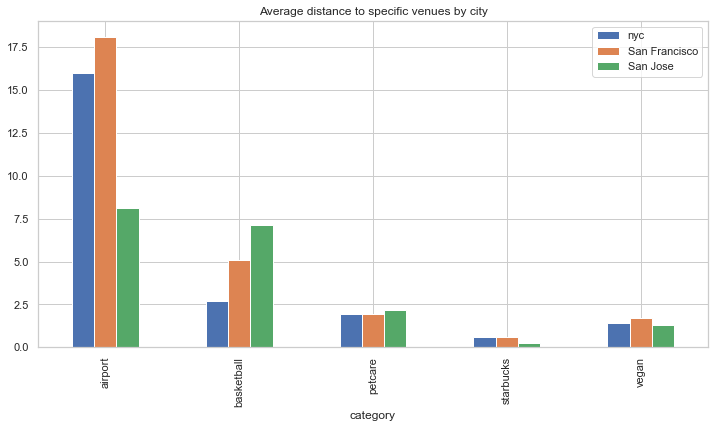

In [211]:
figure_1 = average_all.plot(kind="bar")
plt.title("Average distance to specific venues by city");
figure_1

# Given the average distances as well as the breath of offering within each city, NYC is going to be the chosen city for our new company headquarters.

In [124]:
client = MongoClient("localhost:27017")

In [125]:
db = client.get_database("Ironhack")

In [127]:
ny_areas = db.get_collection("NY Neighborhoods")

# Using $geoIntersects so we know what the area where our initial company is based in

In [132]:
nyc_location = [-73.979247,40.755716]

In [135]:
def type_point (list_):
    return {"type": "Point", "coordinates": list_}

In [136]:
nyc_type_point = type_point(nyc_location)
nyc_type_point

{'type': 'Point', 'coordinates': [-73.979247, 40.755716]}

In [133]:
def find_nyc_area (list_):
    type_point_converted = type_point(list_)

    proy_ = {"name":1, "_id": 0}
    return ny_areas.find_one({"geometry":
                        {"$geoIntersects": 
                            {"$geometry": type_point_converted}}}, proy_)



In [137]:
my_nyc_location = find_nyc_area(nyc_location)
my_nyc_location

{'name': 'Midtown-Midtown South'}

# Now that we know the neighbourhood in NYC, let's do some web scraping from a real state website to see what rent prices in that area look like (see NYC - Web Scraping notebook for reference)